In [296]:
%matplotlib inline

In [297]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy as scipy
from keras.callbacks import TensorBoard
from keras.regularizers import l1, activity_l1
from keras.regularizers import l2, activity_l2
from sklearn import preprocessing  
from datetime import datetime
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding

In [298]:
numpy.random.seed(7)

In [299]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [300]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year

In [301]:
dt = pd.DatetimeIndex(df_train['datetime'])
df_train.set_index(dt, inplace=True)
dt = pd.DatetimeIndex(df_test['datetime'])
df_test.set_index(dt, inplace=True)


def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1

#storms
df_test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#tornado
df_train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [302]:
df_train_train = df_train.drop(['datetime','casual','registered','count'], axis = 1)
#df_train_train = df_train_train.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_train = df_train['count']

In [303]:
df_train_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,year
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,1,5,0,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,1,5,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,1,5,2,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,1,5,3,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,1,5,4,2011


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_test_train.values.astype('float32').reshape(-1,1))
timesteps = 1
indexx = pd.DatetimeIndex(df_train['datetime']).day 
testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
def preprocess_nn(datax,datay):
    train_X_n = preprocessing.scale(datax.values.astype('float32'))
    train_Y_n = scaler.transform(datay.values.astype('float32').reshape(-1,1))
    n = len(train_X_n)
    train_x = train_X_n[~testindex].astype('float32')
    train_y = train_Y_n[~testindex].astype('float32')
    test_x = train_X_n[testindex].astype('float32')
    test_y = train_Y_n[testindex].astype('float32')
    return train_x, train_y, test_x, test_y
def preshape_nn(data_x):
    data_x = numpy.reshape(data_x, (data_x.shape[0]/timesteps, timesteps, data_x.shape[1]))
    return data_x
def learn_nn(train_x, train_y, test_x, test_y, string):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    import numpy as np

    data_dim = len(train_x[0])
    
    #LSTM
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    #model.add(Dense(100))
    model.add(LSTM(100, return_sequences=True,
                   input_shape=(timesteps, data_dim) )) #W_regularizer=l2(0.01) 
    model.add(LSTM(100, return_sequences=True)) #, W_regularizer=l2(0.01)
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(10))  
    model.add(Dense(1, activation='linear'))    
    
    
    #####
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')
    


    x_train = preshape_nn(train_x)
    y_train = train_y #scaler.transform(train_y)


    x_val = preshape_nn(test_x)
    y_val = test_y#scaler.transform(test_y)
    # generate dummy validation data

    now = datetime.now()
    print now.strftime("%Y%m%d-%H%M%S")
    model.fit(x_train, y_train,
              batch_size=100, nb_epoch=100, verbose = 0,
              validation_data=(x_val, y_val),
              callbacks=[TensorBoard(log_dir='logs/' + now.strftime("%Y%m%d-%H%M%S") + string + "/")])
    return model
def model_eval_nn(model, prepro):
    trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[0]))), scaler.inverse_transform(prepro[1])))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))),scaler.inverse_transform(prepro[3])))
    print('Test Score: %.2f RMSE' % (testScore)) 
    plt.plot(scaler.inverse_transform(model.predict(preshape_nn(prepro[2])))-scaler.inverse_transform(prepro[3]),'.')
def get_rmsle(model, prepro):
    diff = pd.DataFrame(np.log(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))).astype('float32') + 1) - np.log(scaler.inverse_transform(prepro[3]).astype('float32') + 1))
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error).values[0]

In [ ]:
pre1 = preprocess_nn(df_train_train,df_test_train)
m1 = learn_nn(pre1[0],pre1[1],pre1[2],pre1[3],'MG')
model_eval_nn(m1,pre1)
get_rmsle(m1,pre1)

Train Score: 12.82 RMSE
Test Score: 15.20 RMSE


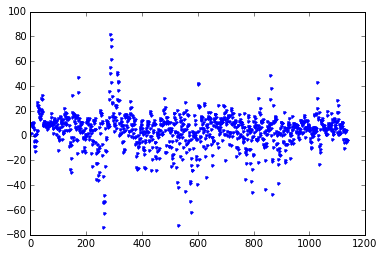

In [54]:
indexx = pd.DatetimeIndex(df_train['datetime'][df_train['year'] == 2011]).day 
testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
pre2 = preprocess_nn(df_train_train[df_train['year'] == 2011],df_train['casual'][df_train['year'] == 2011])
m2 = learn_nn(pre2[0],pre2[1],pre2[2],pre2[3],'MAC')
model_eval_nn(m2,pre2)

Train Score: 23.92 RMSE
Test Score: 29.52 RMSE


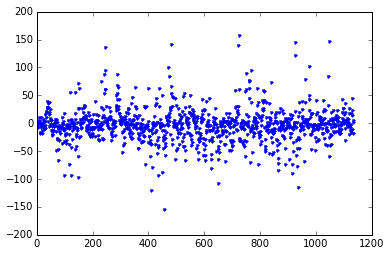

In [55]:
pre3 = preprocess_nn(df_train_train[df_train['year'] == 2011],df_train['registered'][df_train['year'] == 2011])
m3 = learn_nn(pre3[0],pre3[1],pre3[2],pre3[3],'MAR')
model_eval_nn(m3,pre3)

Train Score: 22.03 RMSE
Test Score: 29.08 RMSE


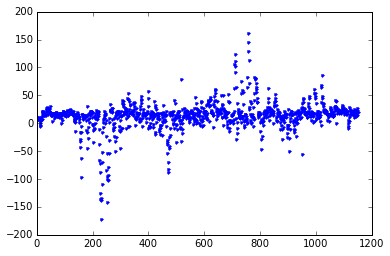

In [56]:
indexx = pd.DatetimeIndex(df_train['datetime'][df_train['year'] == 2012]).day 
testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
pre4 = preprocess_nn(df_train_train[df_train['year'] == 2012],df_train['casual'][df_train['year'] == 2012])
m4 = learn_nn(pre4[0],pre4[1],pre4[2],pre4[3],'MBC')
model_eval_nn(m4,pre4)

Train Score: 34.93 RMSE
Test Score: 50.15 RMSE


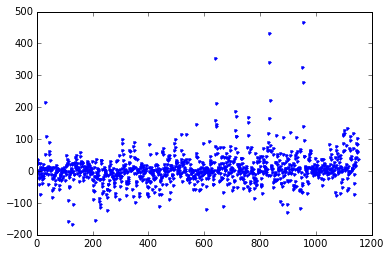

In [57]:
pre5 = preprocess_nn(df_train_train[df_train['year'] == 2012],df_train['registered'][df_train['year'] == 2012])
m5 = learn_nn(pre5[0],pre5[1],pre5[2],pre5[3],'MBR')
model_eval_nn(m5,pre5)

In [278]:
df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year
df_test_test = df_test.drop(['datetime'], axis = 1)
#df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_t = preprocessing.scale(df_test_test.values)
df_test_r = preshape_nn(df_test_t)


In [279]:
out2 = scaler.inverse_transform(m2.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2011].values.astype('float32'))))).astype(int)
out3 = scaler.inverse_transform(m3.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2011].values.astype('float32'))))).astype(int)
out4 = scaler.inverse_transform(m4.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2012].values.astype('float32'))))).astype(int)
out5 = scaler.inverse_transform(m5.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2012].values.astype('float32'))))).astype(int)
out2[out2<0] = 0
out3[out3<0] = 0
out4[out4<0] = 0
out5[out5<0] = 0
out2 = out2[:,0]
out3 = out3[:,0]
out4 = out4[:,0]
out5 = out5[:,0]

In [280]:
outb = np.concatenate((np.array(out2 + out3),np.array(out4 + out5)), axis = 0)
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': outb})
pred = pred[['datetime','count']]
pred.to_csv("pred2.csv", index = False)

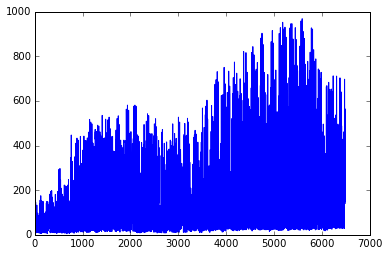

In [281]:
plt.plot(outb)

In [282]:
pred = m1.predict(df_test_r)
out = scaler.inverse_transform(pred).astype(int)
out[out<0] = 0
out = out[:,0]
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]
pred.to_csv("pred.csv", index = False)

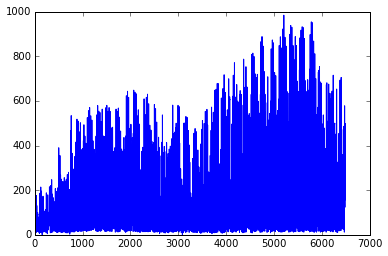

In [283]:
plt.plot(out)

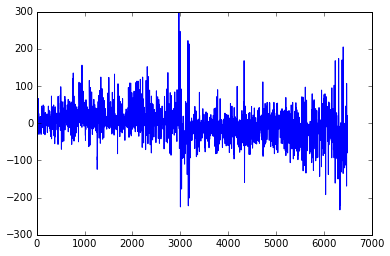

In [284]:
plt.plot(out-outb)

[ 0.98698431]


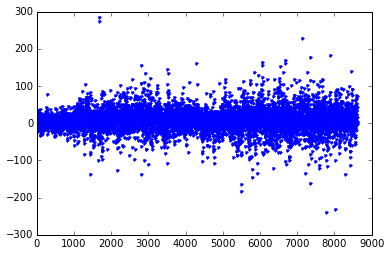

In [285]:
plt.plot(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0])))-scaler.inverse_transform(pre1[1]),'.')
print scipy.stats.pearsonr(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0]))),scaler.inverse_transform(pre1[1]))[0]

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)
train_y_r_e = np.exp(train_y)
trainPredict = np.exp(scaler.inverse_transform(trainPredict))
test_y_r_e = np.exp(test_y)
testPredict = np.exp(scaler.inverse_transform(testPredict))

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_r_e, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_r_e, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
print scipy.stats.pearsonr(train_y_r_e,trainPredict[:,0])[0]
plt.plot(train_y_r_e,trainPredict,'.')

In [ ]:
plt.plot(train_y_r_e-trainPredict[:,0])

In [ ]:
print scipy.stats.pearsonr(test_y_r_e,testPredict[:,0])[0]
plt.plot(test_y_r_e,testPredict,'.')

In [ ]:
df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year
df_test_test = df_test.drop(['datetime'], axis = 1)
#df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_t = preprocessing.scale(df_test_test.values)
df_test_r = numpy.reshape(df_test_t, (df_test_t.shape[0], timesteps , df_test_t.shape[1]))
pred = model.predict(df_test_r)

In [ ]:
out = np.exp(scaler.inverse_transform(pred)).astype(int)
out[out<0] = 0
out = out[:,0]

In [ ]:
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]

In [ ]:
pred.to_csv("pred.csv", index = False)

In [ ]:
predicted = pd.read_csv('pred.csv')

In [ ]:
plt.plot(predicted['count'])

In [ ]:
plt.hist(predicted['count'])

In [ ]:
plt.plot(df_train['count'].values)

In [ ]:
plt.plot(predicted['count'][500:1000])

In [ ]:
a= []
for i in range(10):
    b = df_train['datetime'][i <= pd.DatetimeIndex(df_train['datetime']).dayofyear < 9*(i+1)].values
    a.append(b)
print a

In [ ]:
a[1]

In [ ]:
df_train['datetime'][0:24*10-7][25:24+24]

In [ ]:
x_train = np.random.random((1000, 8, 3))


In [ ]:
x_train[0]

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 8
nb_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()

model.add(LSTM(100, return_sequences=True,
               input_shape=(timesteps, data_dim) )) #W_regularizer=l2(0.01) 
model.add(LSTM(100, return_sequences=True)) #, W_regularizer=l2(0.01)
model.add(LSTM(100))  
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop')

# generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = 10*np.random.random((1000))

# generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100))

now = datetime.now()

model.fit(x_train, y_train,
          batch_size=64, nb_epoch=100,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='logs1/' + now.strftime("%Y%m%d-%H%M%S") + "/")])